<h1 id="ALG_003_EXP_001-Baseline-MacLean_et_al-prl">Simple parallelization of the pipeline using python</h1>
<h2>For analysis and discussion, please visit: <a href="ALG_003_EXP_001-VIS.ipynb">ALG_003_EXP_001-VIS</a></h2>


In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os
sys.path.append(os.path.join("..", ".."))

import numpy as np
import imp
import cv2
import matplotlib.pyplot as plt
import gc
from components.utils.CSVWriter2 import Wrapper as l
from components.utils.Metrix import Wrapper as me
from components.utils import visualisation_utils as vu

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.ParallelMatcherNWMacLean import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv

import project_helpers
###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:
ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_003_EXP_001-Baseline-MacLean_et_al-prl"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

..\..\datasets\middlebury\middlebury_2003\teddy
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\nonocc.png
..\..\datasets\middlebury\middlebury_2003\cones
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\nonocc.png


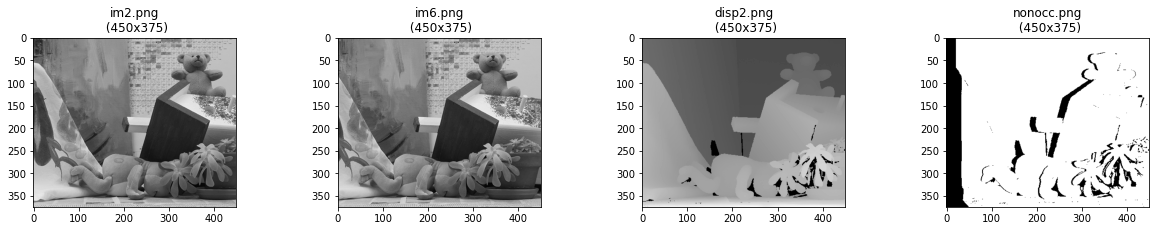

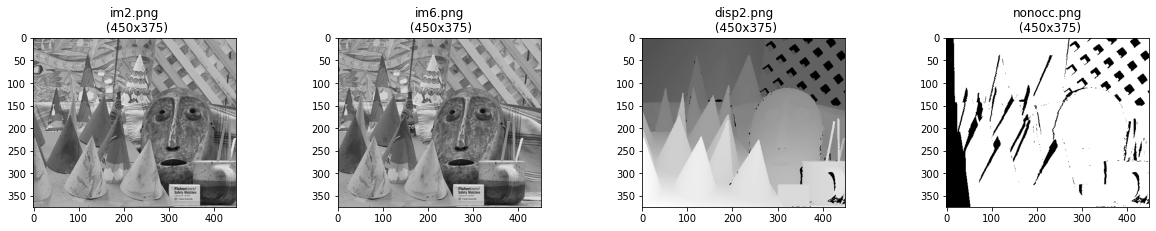

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# The addition of occluded areas to the pristine groundtruth images

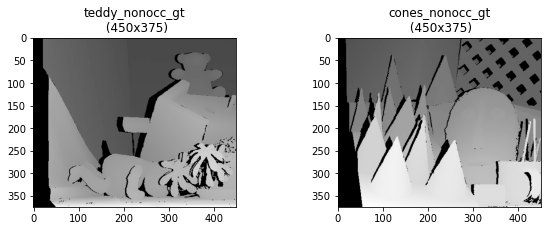

In [4]:
###################################################################
# 2. Occluded areas are added to the groundtruths #################
###################################################################

nonocc_gts = list()
for imgs, paths in loaded_imgs_and_paths:
    temp = mbu.add_masks_to_raw_disparity(imgs[2], imgs[3])
    nonocc_gts.append(mbu.add_masks_to_raw_disparity(imgs[2], imgs[3]))
plu.plot_images(nonocc_gts, ["teddy_nonocc_gt", "cones_nonocc_gt"])

# Benchmarking and evaluation

In [5]:
###################################################################
# 3.1 Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 60
GAP = -20
EGAP = -1

SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)
saved_image_names = []


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

File ..\..\experiments\logs\ALG_003_EXP_001-Baseline-MacLean_et_al-prl.csv already exists, header has not been written.


In [6]:
###################################################################
# 3.2 Matching ####################################################
###################################################################

results = []


matcher = m(MATCH, GAP, EGAP)
EXP_PARAMS["init_method"] = "maclean_et_al"
for i, scene in enumerate(SCENES):
    EXP_PARAMS["scene"] = scene
    EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
    EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
    occ = loaded_imgs_and_paths[i][0][3]
    gt = loaded_imgs_and_paths[i][0][2]
    
    matcher.initialize(loaded_imgs_and_paths[i][0][0], loaded_imgs_and_paths[i][0][1])
    
    tic = time.time()
    matcher = u.executeParallelMatching(matcher)
    toc=time.time()
    
    ###################################################################
    # Saving image ####################################################
    ###################################################################
    EXP_PARAMS["runtime"] = toc-tic

    disp = matcher.lastDisparity
    disp = disp*4
    results.append(disp)
    
    temp_path = u.save_disparity(SAVE_PATH, disp)
    saved_image_names.append(os.path.split(temp_path)[-1])
    
    ###################################################################
    # Benchmarking & logging ##########################################
    ###################################################################
            
    EXP_PARAMS["image_filename"] = temp_path

    EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = True
    
    EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
    BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

    csv_logger.append_new_sm_results(EXP_PARAMS, csv.get_header_v3())

    EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False
    EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
    BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

    csv_logger.append_new_sm_results(EXP_PARAMS, csv.get_header_v3())


Matcher has been initialized.
Aligning scanlines has finished. It has taken: 44.60 seconds.
Matcher has been initialized.
Aligning scanlines has finished. It has taken: 71.70 seconds.


In [3]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad4", inplace=True) 
experiment_log.head(6)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
0,ALG_003_EXP_001-Baseline-MacLean_et_al-prl,60,-20,-1,components.matchers.ParallelMatcherNWMacLean,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_003_EXP_001-Baseli...,450x375,...,True,2374725.0,1463.938459,14.072444,15717.493916,0.621316,0.480462,0.345624,0.204836,44.821299
1,ALG_003_EXP_001-Baseline-MacLean_et_al-prl,60,-20,-1,components.matchers.ParallelMatcherNWMacLean,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_003_EXP_001-Baseli...,450x375,...,False,1468417.0,844.006360,9.945188,11163.260411,0.661032,0.500051,0.346378,0.185546,44.821299
3,ALG_003_EXP_001-Baseline-MacLean_et_al-prl,60,-20,-1,components.matchers.ParallelMatcherNWMacLean,maclean_et_al,middlebury,cones,experiments\disparities\ALG_003_EXP_001-Baseli...,450x375,...,False,1578996.0,807.880883,10.970888,10783.091579,0.662945,0.545767,0.393515,0.243945,71.950726
2,ALG_003_EXP_001-Baseline-MacLean_et_al-prl,60,-20,-1,components.matchers.ParallelMatcherNWMacLean,maclean_et_al,middlebury,cones,experiments\disparities\ALG_003_EXP_001-Baseli...,450x375,...,True,2810608.0,1621.035662,16.655455,16539.340011,0.631212,0.531271,0.401221,0.273588,71.950726


<ipython-input-4-4e26aad9974f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-4e26aad9974f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-4e26aad9974f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



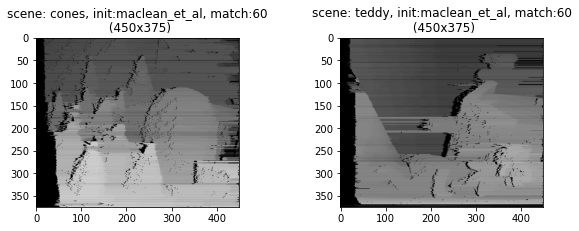

In [4]:
image_reader_func = lambda filepath: cv2.imread(str(project_helpers.fix_win_rel_paths(filepath)))

filtered_log= experiment_log[experiment_log["are_occlusions_errors"] == False]
filtered_log["loaded_imgs"] = [image_reader_func(filepath) for filepath in filtered_log["image_filename"]]
filtered_log["annotation"] = [("scene: {0}, init:{1}, match:{2}".format(scene, init, m)) for scene, init, m in filtered_log[["scene", "init_method", "match"]].values]
filtered_log.sort_values(by=["match", "scene"], inplace=True)
plu.plot_images(filtered_log["loaded_imgs"].values, filtered_log["annotation"].values)

Please <a href="ALG_003_EXP_001-VIS.ipynb"> ALG_003_EXP_001-VIS</a> for results.